In [5]:
# Make a bar chart to show the number of species in the reaction that come from group additivity vs. library
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import rmgpy.chemkin

%matplotlib inline


In [8]:
# get all the mechanism folders:
mech_folders = glob.glob('/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_*')

In [22]:
print(mech_folders)

['/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240126', '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240315', '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240403']


In [29]:
# get all the possible families

families = set()

for i in range(len(mech_folders)):
    chemkin = os.path.join(mech_folders[i], 'chem_annotated.inp')
    print(f'Getting families from {chemkin}')
    transport = os.path.join(mech_folders[i], 'tran.dat')
    species_dict = os.path.join(mech_folders[i], 'species_dictionary.txt')
    species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(chemkin, dictionary_path=species_dict, transport_path=transport, use_chemkin_names=True)

    for rxn in reaction_list:
        try:
            families.add(rxn.family)
        except AttributeError:
            continue
print(families)
# # get the reaction sources
# families = ['R_Recombination', 'CO_Disproportionation', 'H_Abstraction', 'Birad_R_Recombination', 'Disproportionation', 'intra_H_migration']
# libraries = ['BurkeH2O2inN2', 'CurranPentane', 'Klippenstein_Glarborg2016', 'combustion_core/version5', 'FFCM1(-)', 'C2H4+O_Klipp2017']


Getting families from /work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240126/chem_annotated.inp
Getting families from /work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240315/chem_annotated.inp
Getting families from /work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240403/chem_annotated.inp
{'intra_H_migration', 'CO_Disproportionation', 'R_Recombination', 'R_Addition_COm', 'Disproportionation', 'Cyclic_Ether_Formation', 'R_Addition_MultipleBond', 'Birad_R_Recombination', 'BurkeH2O2inN2', 'H_Abstraction', 'harris_butane'}


In [30]:
sp_counts = np.zeros((len(mech_folders), 2))  # library, GAV
rxn_counts = np.zeros((len(mech_folders), 3))  #, library, estimate, PDEP
for i in range(len(mech_folders)):
    chemkin = os.path.join(mech_folders[i], 'chem_annotated.inp')
    transport = os.path.join(mech_folders[i], 'tran.dat')
    species_dict = os.path.join(mech_folders[i], 'species_dictionary.txt')
    species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(chemkin, dictionary_path=species_dict, transport_path=transport, use_chemkin_names=True)

    # get the species sources
    for sp in species_list:
        if 'library' in sp.thermo.comment.lower():
            sp_counts[i, 0] += 1
        if 'group' in sp.thermo.comment.lower():
            sp_counts[i, 1] += 1
    assert sp_counts[i, 0] + sp_counts[i, 1] == len(species_list)
    
    
    families = set()
    for rxn in reaction_list:
        try:
            families.add(rxn.family)
        except AttributeError:
            continue
#     print(families)
    
    # get the reaction sources # ---------------- HAVE TO FILL THIS IN MANUALLY BASED ON THE ABOVE
    families = ['intra_H_migration', 'CO_Disproportionation', 'R_Recombination', 'R_Addition_COm', 'Disproportionation', 'Cyclic_Ether_Formation', 'R_Addition_MultipleBond', 'Birad_R_Recombination', 'H_Abstraction']
    libraries = ['BurkeH2O2inN2', 'harris_butane']
    
    for rxn in reaction_list:
        try:
            if rxn.family in families:
                rxn_counts[i, 1] += 1
            elif rxn.family in libraries:
                rxn_counts[i, 0] += 1
        except AttributeError:
            rxn_counts[i, 2] += 1

    assert rxn_counts[i, 0] + rxn_counts[i, 1] + rxn_counts[i, 2] == len(reaction_list)
    

<Figure size 640x480 with 0 Axes>

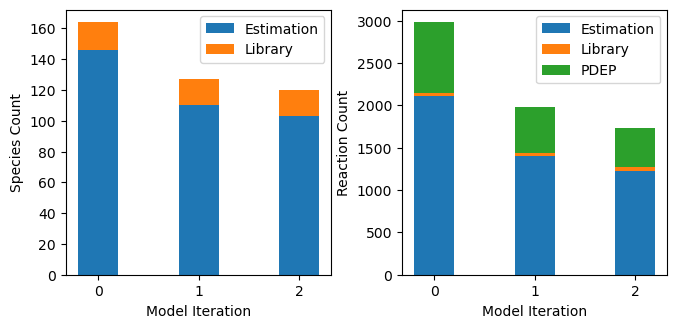

In [71]:
# Plot both on the same figure as subplots
fig = plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))
fig.tight_layout(pad=2)
# fig, axs = plt.subplots(1, 2)

w = 0.4

axs[0].bar([str(i) for i in range(len(mech_folders))], sp_counts[:, 1], width=w, label='Estimation')
axs[0].bar([str(i) for i in range(len(mech_folders))], sp_counts[:, 0], bottom=sp_counts[:, 1], width=w, label='Library')
axs[0].set_xlabel('Model Iteration')
axs[0].set_ylabel('Species Count')
axs[0].legend()

axs[1].bar([str(i) for i in range(len(mech_folders))], rxn_counts[:, 1], width=w, label='Estimation')
axs[1].bar([str(i) for i in range(len(mech_folders))], rxn_counts[:, 0], bottom=rxn_counts[:, 1], width=w, label='Library')
axs[1].bar([str(i) for i in range(len(mech_folders))], rxn_counts[:, 2], bottom=rxn_counts[:, 0] + rxn_counts[:, 1], width=w, label='PDEP')

axs[1].set_xlabel('Model Iteration')
axs[1].set_ylabel('Reaction Count')
axs[1].legend()



plt.show()
